### 1-D Richards equation solver code
- formulation based on a backward Euler implementation of the mixed theta-head formulation of the 1-D Richards equation, with a modified Picard iteration finite differencing solution scheme, with a modified Picard iteration finite differencing solution scheme.

- The soil water retention parameterization used is that of van Genuchten 
 [1980], and this code requires the corresponding MATLAB function        
 vanGenuchten.m.  
 
 - coordinate axis:  positive  downward
         z[0] = 0  (top)
         z[-1] = 100  (bottom)

In [60]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import time

In [2]:
%matplotlib inline

In [3]:
def vanGenuchten(h,phi) :
    alpha   = phi[0]
    theta_S = phi[1]
    theta_R = phi[2]
    n       = phi[3]
    m       = phi[4]
    Ksat    = phi[5] 
    # Compute the volumetric moisture content
    theta = (theta_S - theta_R)/(1 + (alpha*abs(h))**n)**m + theta_R; 
    ## Compute the effective saturation
    Se = ((theta - theta_R)/(theta_S - theta_R)); 
    # Compute the hydraulic conductivity
    K = Ksat*Se**(1./2)*(1 - (1 - Se**(1./m))**m)**2; 
    # Compute the specific moisture storage
    C =  -alpha*n*np.sign(h)*(1./n - 1)*(alpha*abs(h))**(n - 1)*(theta_R - 
         theta_S)*((alpha*abs(h))**n + 1)**(1/n - 2);
    try:
        for i in range(len(h)):
            if h[i] > 0:
                K[i] = Ksat
                C[i] = 0.
                theta[i] = theta_S
    except TypeError:
        if h > 0:
            K = Ksat
            C = 0.
            theta = theta_S
    return [C,K,theta]

In [4]:
# Define van Genuchten parameters
alpha   = 0.0335
theta_S = 0.368;
theta_R = 0.102;
lambdA  = 0.25
n       = lambdA + 1
m       = lambdA/n
Ksat    = 0.09

# Store van Genuchten parameters in array
phi = np.zeros(6)
phi[0] = alpha
phi[1] = theta_S
phi[2] = theta_R
phi[3] = n
phi[4] = m
phi[5] = Ksat

In [5]:
# set up vertical grid 
dz = 1.; # [cm]
zmin = 0.; # [cm]
zmax = 100.; # [cm]
z = np.arange(zmin, zmax+1, dz)
nz   =  z.shape[0]

In [71]:
# Define matrices that we'll need in solution
BottomBoundCon = 1  # 0 = constant head, 1 = free drainage
DeltaPlus  = np.diag(-np.ones(nz)) + np.diag(np.ones(nz-1), 1)
DeltaPlus[0,:] = 0
DeltaPlus[nz-1,:] = 0

DeltaMinus = np.diag(np.ones(nz)) + np.diag(-np.ones(nz-1),-1);
DeltaMinus[0,:] = 0
DeltaMinus[nz-1,:] = 0

MPlus = np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)
MPlus[0,0] = 2
MPlus[0,1:nz-1] = 0
MPlus[nz-1,nz-1] = 2
MPlus[nz-1,:nz-1] = 0  # not needed

MMinus = np.diag(np.ones(nz)) + np.diag(np.ones(nz-1),-1)
MMinus[0,0] = 2
MMinus[0,1:nz-1] = 0  # not needed
MMinus[nz-1,nz-1] = 2
MMinus[nz-1,:nz-1] = 0 

In [109]:
# Define ICs boundary conditions at top and bottom
hinit = np.arange(nz)*-5
hinit = -1000*np.ones(nz)
hinit[0] = -30.
htop = hinit[0]
hbottom = hinit[-1]
flux = 0.001
set_flux = 1

In [110]:
# Define time variables
stop_tol = 1e-5  # Stopping tolerance [cm]
dt = .1# [s]

tmin = 0. # [s]
tmax = 1.
# times = np.arange(tmin, tmax, dt)[:nt]  #(tmin:dt:tmax);

# Define a storage container to store the pressure heads and soil moistures
[Ctop,Ktop,thetatop] = vanGenuchten(htop,phi)
[Cbottom,Kbottom,thetabottom] = vanGenuchten(hbottom,phi)
[Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 
H = [] # np.zeros([nz,nt])
K =[] # np.zeros([nz,nt])
C = [] # np.zeros([nz,nt])
H.append(hinit)
K.append(Kinit)
C.append(Cinit)

THETA = [] # np.zeros([nz,nt])
THETA.append(thetainit)
ktop = [] # np.zeros([ nt])
ktop.append(Ktop)
kbot = [] # np.zeros([ nt])
kbot.append(Kbottom)
error = [] # np.zeros([nt])
t = [] # np.zeros([nt])
dt_array = [] # np.zeros([nt])
fluxin = []
fluxout= []
newmass = []

In [111]:
# Figures

start_time = time.time()
iterations = []  # Define array for iteration counter
tc = 0
t.append(tc)
niter = 0
dtc = dt
i = 0
# for i in range(1, nt):   # Initialize the Picard iteration solver
while tc < tmax:
    i += 1
    dtc = dt
    hnp1m =  H[i-1]  
    thetan = THETA[i-1]   
    stop_flag = 0  #Define a dummy stopping variable
    while stop_flag==0:
        if niter > 100:
            hnp1m =  H[i-1]  
            thetan = THETA[i-1]   
            dtc = dtc/10.
            niter = 0
            if tc + dtc > tmax:
                dtc = tmax - tc
                print dtc
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi)
        if set_flux == 1:
            kt =  (knp1m[1] + knp1m[0])/2.
            hnp1m[0] = hnp1m[1] + dz + dz*flux/kt
        Cdiag = np.diag(cnp1m) # Compute the individual elements of the A matrix for LHS
        kbarplus = (1/2.)*MPlus.dot(knp1m)
        Kbarplus = np.diag(kbarplus)
        kbarminus = (1/2.)*MMinus.dot(knp1m)
        Kbarminus = np.diag(kbarminus)
        A = (1./dtc)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - Kbarminus.dot(DeltaMinus)) 
        #  Compute the residual of MPFD (RHS)
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
            (1./dz)*(kbarplus - kbarminus) - (1./dtc)*(thetanp1m - thetan) 
        deltam = np.linalg.pinv(A).dot(R_MPFD)    #  Compute deltam for iteration level m+1
        niter = niter + 1      # Increment iteration counter 
        if max(abs(deltam[1:(nz-1)]))<stop_tol:
            stop_flag = 1
            hnp1mp1 = hnp1m + deltam # Force boundary conditions       
            if set_flux == 1:
                kt =  (knp1m[1] + knp1m[0])/2.
                hnp1mp1[0] = hnp1mp1[1] + dz + dz*flux/kt
            else:
                hnp1mp1[0] = htop            
            if BottomBoundCon==0:
                hnp1mp1[nz-1] = hbottom;
            elif (BottomBoundCon==1):
                hnp1mp1[nz-1] = hnp1m[nz-2];
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
            thetanp1mp1 = thetanp1m;
            knp1mp1 = knp1m
            cnp1mp1 = cnp1m            
            hnp1m = hnp1mp1; 
            tc = tc + dtc
        else:
            hnp1mp1 = hnp1m + deltam;
            hnp1m = hnp1mp1; # Force boundary conditions
            # hnp1m[0] = htop;
            if set_flux == 1:
                kt = (knp1m[1] + knp1m[0])/2.
                hnp1m[0] = hnp1m[1] + dz + dz*flux/kt
            else:
                hnp1m[0] = htop
            if BottomBoundCon==0:
                hnp1m[nz-1] = hbottom;
            elif BottomBoundCon==1:
                hnp1m[nz-1] = hnp1m[nz-2];
    # Closes while(stop_flag==0) H(:,i) = hnp1mp1;
    t.append(tc)
    dt_array.append(dtc)
    THETA.append(thetanp1mp1)
    H.append(hnp1mp1)
    K.append(knp1mp1)
    C.append(cnp1mp1)
    ktop.append((K[i][0] + K[i][1])/2.) 
    kbot.append((K[i][-1] + K[i][-2])/2.)
    error.append(np.sum(A.dot(deltam))*dtc)
    fluxin.append( -ktop[i]*((H[i][1] - H[i][0])/dz + 1.) )  # top flux (cm/s)
    fluxout.append(kbot[i]*((H[i][-1] - H[i][-2])/dz + 1. )) # bottom flux (cm/s)
    newmass.append((THETA[i] - THETA[i-1]).sum(0)/dtc )  #  change in mass (cm/s)
#     error[i] = dz*np.sum(C[1:-1,i]*deltam[1:-1]) -  kbot[i]*(deltam[-1] - deltam[-2])*dt/dz \
#         + ktop[i]*(deltam[1] - deltam[0])*dt/dz
    if (np.mod(i,1)==0):
        print t[i],
    iterations.append(niter)  #  save number of iterations
print("--- %s seconds ---" % (time.time() - start_time))

fluxin = np.array(fluxin)
fluxout = np.array(fluxout)
newmass = np.array(newmass)
error = np.array(error)
dt_array = np.array(dt_array)
t = np.array(t)


1e-07 0.0100001 0.0200001 0.0300001 0.0400001 0.0500001 0.0600001 0.0700001 0.0800001 0.0900001 0.1000001 0.1100001 0.1200001 0.1300001 0.1400001 0.1500001 0.1600001 0.1700001 0.1800001 0.1900001 0.2000001 0.2100001 0.2200001 0.2300001 0.2400001 0.2500001 0.2600001 0.2700001 0.2800001 0.2900001 0.3000001 0.3100001 0.3200001 0.3300001 0.3400001 0.3500001 0.3600001 0.3700001 0.3800001 0.3900001 0.4000001 0.4100001 0.4200001 0.4300001 0.4400001 0.4500001 0.4600001 0.4700001 0.4800001 0.4900001 0.5000001 0.5100001 0.5200001 0.5300001 0.5400001 0.5500001 0.5600001 0.5700001 0.5800001 0.5900001 0.6000001 0.6100001 0.6200001 0.6300001 0.6400001 0.6500001 0.6600001 0.6700001 0.6800001 0.6900001 0.7000001 0.7100001 0.7200001 0.7300001 0.7400001 0.7500001 0.7600001 0.7700001 0.7800001 0.7900001 0.8000001 0.8100001 0.8200001 0.8300001 0.8400001 0.8500001 0.8600001 0.8700001 0.8800001 0.8900001 0.9000001 0.9100001 0.9200001 0.9300001 0.9400001 0.9500001 0.9600001 0.9700001 0.9800001 0.9900001 0.00

In [104]:
dtc

0.1

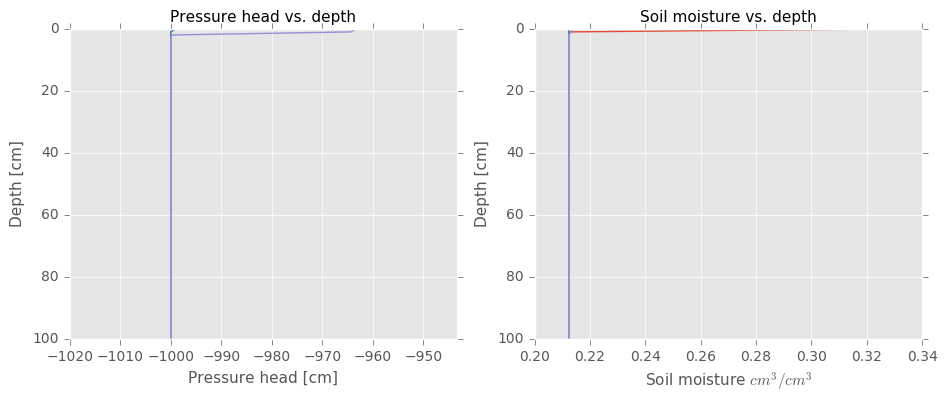

In [112]:
fig = plt.figure(1, figsize = (11,4)); 
ax = plt.subplot(121)
plt.plot(hinit,z);
plt.xlabel('Pressure head [cm]',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.xlim( np.min(H)-20,  np.max(H)+20)
plt.ylim(100, 0)
plt.gca().invert_yaxis()
plt.title('Pressure head vs. depth', fontsize=  11)
plt.ylim(100, 0)
ax = plt.subplot(122)
plt.plot(thetainit,z)
plt.xlabel('Soil moisture $cm^3/cm^3$',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.gca().invert_yaxis()
plt.title('Soil moisture vs. depth',fontsize=  11)

for i in  range(1, len(t), 100):
    ax = plt.subplot(121)
    plt.plot(H[i],z)
    ax = plt.subplot(122)
    plt.plot(THETA[i],z)


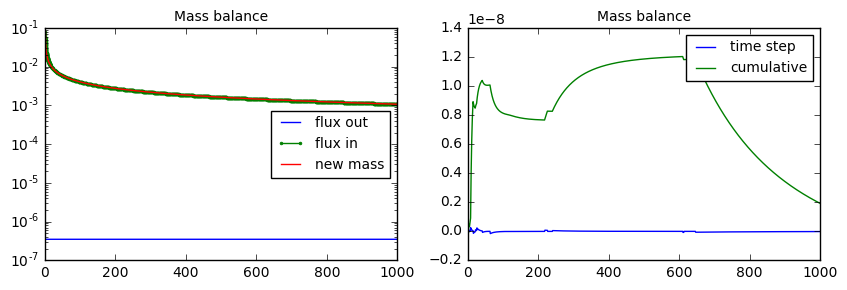

In [54]:
#  plot mass balance terms
plt.figure(1, figsize = (10,3))
ax = plt.subplot(121)
plt.title('Mass balance', fontsize = 10)
plt.plot(t[1:], fluxout/dt_array, label = 'flux out')
plt.plot(t[1:], fluxin/dt_array, '.-', ms = 4, label = 'flux in')
plt.semilogy(t[1:], newmass/dt_array, label = 'new mass')
plt.legend(loc = 'best', fontsize = 10)
ax = plt.subplot(122)
plt.title('Mass balance', fontsize = 10)
plt.plot(t[1:], fluxin - newmass + fluxout - error ,  label = 'time step')
plt.plot(t[1:], np.cumsum(fluxin - newmass + fluxout - error ), label =  'cumulative')
# plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:]  ), '--', label =  'unclosed')
# plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass), label =  'cumulative')
plt.legend(fontsize = 10)
# (fluxin[1:] - newmass  + fluxout[1:] +error[1:])

In [56]:
plt.figure(5);
plt.plot(t[1:nt],iterations,'o-');
plt.xlabel('Time [s]');
plt.ylabel('Number of iterations');

TypeError: 'float' object has no attribute '__getitem__'

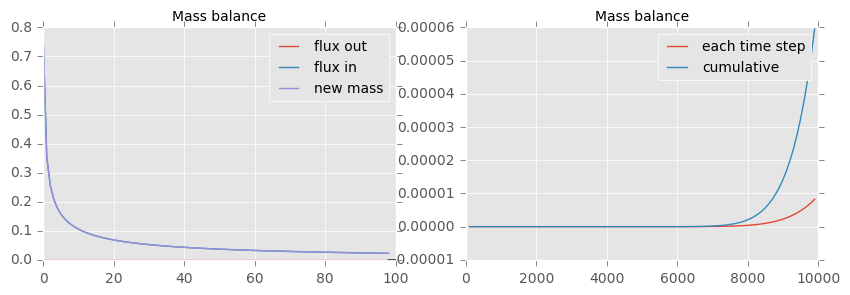

In [18]:
#  plot mass balance terms
plt.figure(1, figsize = (10,3))
ax = plt.subplot(121)
plt.title('Mass balance', fontsize = 10)
plt.plot(fluxout[1:], label = 'flux out')
plt.plot(fluxin[1:], label = 'flux in')
plt.plot(newmass, label = 'new mass')
plt.legend(fontsize = 10)
ax = plt.subplot(122)
plt.title('Mass balance', fontsize = 10)
plt.plot(t[1:], fluxin[1:] - newmass + fluxout[1:],  label = 'each time step')
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass+ fluxout[1:]), label =  'cumulative')
plt.legend(fontsize = 10)